# Siamese Neural Network for FDA Adverse Events-Regulations Matching

## Built and Trained from Scratch using PyTorch

### Goal: 
Implements a Siamese Neural Network architecture from scratch to learn similarity between FDA adverse events and regulation which is to identify which regulation(s) is/are applicable to a FDA issued letter.

### Architecture:
- Custom embedding layer (random initialization)
- Bidirectional LSTM layers
- Fully connected layers
- Cosine similarity computation
- Trained end-to-end with PyTorch

### Purpose:
- Build Siamese model from scratch

## Install and Import Libraries

In [1]:
# Install required packages
import subprocess
import sys

packages = [
    "torch",
    "torchvision",
    "pandas",
    "numpy",
    "matplotlib",
    "seaborn",
    "scikit-learn",
    "tqdm",
    "pyarrow"
]

for package in packages:
    try:
        __import__(package.replace("-", "_"))
        print(f"✓ {package} already installed")
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package, "--quiet"])

print("\n✓ All packages ready")

✓ torch already installed
✓ torchvision already installed
✓ pandas already installed
✓ numpy already installed
✓ matplotlib already installed
✓ seaborn already installed
Installing scikit-learn...
✓ tqdm already installed
✓ pyarrow already installed

✓ All packages ready


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import json
import pickle
from collections import Counter
import re

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("✓ Libraries imported")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

✓ Libraries imported
PyTorch version: 2.9.0
CUDA available: False


## Setup Paths and Configuration

In [3]:
# Setup paths
BASE_DIR = Path("/Users/Kay Michnicki/AllCode/FDA Data Scraping")

# Data directories
AE_DATA_DIR = BASE_DIR / "fda_adverse_events_recalls" / "adverse_events"
REGULATIONS_DATA_DIR = BASE_DIR / "fda_output_cleaned"
OUTPUT_DIR = BASE_DIR / "siamese_network_output"
OUTPUT_DIR.mkdir(exist_ok=True)

# Model configuration
EMBEDDING_DIM = 128  # Dimension of word embeddings
HIDDEN_DIM = 256  # LSTM hidden dimension
NUM_LAYERS = 2  # Number of LSTM layers
DROPOUT = 0.3
MAX_VOCAB_SIZE = 10000  # Maximum vocabulary size
MAX_SEQ_LENGTH = 512  # Maximum sequence length
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 10
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("SIAMESE NEURAL NETWORK - BUILT FROM SCRATCH")
print(f"\nBase directory: {BASE_DIR}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"\nModel Configuration:")
print(f"  Embedding dimension: {EMBEDDING_DIM}")
print(f"  Hidden dimension: {HIDDEN_DIM}")
print(f"  LSTM layers: {NUM_LAYERS}")
print(f"  Dropout: {DROPOUT}")
print(f"  Max sequence length: {MAX_SEQ_LENGTH}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Device: {DEVICE}")

SIAMESE NEURAL NETWORK - BUILT FROM SCRATCH

Base directory: /Users/Kay Michnicki/AllCode/FDA Data Scraping
Output directory: /Users/Kay Michnicki/AllCode/FDA Data Scraping/siamese_network_output

Model Configuration:
  Embedding dimension: 128
  Hidden dimension: 256
  LSTM layers: 2
  Dropout: 0.3
  Max sequence length: 512
  Batch size: 32
  Learning rate: 0.001
  Epochs: 10
  Device: cpu


## Load and Prepare Data

In [4]:
# Load adverse events data
print("Loading adverse events data...")
ae_files = {
    'Drugs': AE_DATA_DIR / "drug_adverse_events.parquet",
    'Biologics': AE_DATA_DIR / "biologics_adverse_events.parquet",
    'MedicalDevices': AE_DATA_DIR / "device_adverse_events.parquet"
}

dfs_ae = []
for category, file_path in ae_files.items():
    if file_path.exists():
        df = pd.read_parquet(file_path)
        df['product_category'] = category
        dfs_ae.append(df)
        print(f"✓ Loaded {len(df):,} {category} adverse events")

df_ae = pd.concat(dfs_ae, ignore_index=True) if dfs_ae else pd.DataFrame()
print(f"✓ Total adverse events: {len(df_ae):,}")

# Load regulations data
print("\nLoading regulations data...")
regulations_file = REGULATIONS_DATA_DIR / "fda_cleaned.parquet"
if regulations_file.exists():
    df_regulations = pd.read_parquet(regulations_file)
    print(f"✓ Loaded {len(df_regulations):,} regulations")
else:
    print(f"⚠ Regulations file not found: {regulations_file}")
    df_regulations = pd.DataFrame()

# Create text fields for adverse events
if 'ae_text' not in df_ae.columns and len(df_ae) > 0:
    def create_ae_text(row):
        parts = []
        if pd.notna(row.get('drug_product_name')):
            parts.append(f"Product: {row['drug_product_name']}")
        if pd.notna(row.get('adverse_reactions')):
            parts.append(f"Adverse reactions: {row['adverse_reactions']}")
        if pd.notna(row.get('serious')) and str(row['serious']) == '1':
            parts.append("Serious adverse event")
        return ". ".join(parts) if parts else "No information"
    
    df_ae['ae_text'] = df_ae.apply(create_ae_text, axis=1)

print(f"\n✓ Data loaded and prepared")
print(f"  Adverse events: {len(df_ae):,}")
print(f"  Regulations: {len(df_regulations):,}")

Loading adverse events data...
✓ Loaded 1,000 Drugs adverse events
✓ Loaded 51 Biologics adverse events
✓ Loaded 1,000 MedicalDevices adverse events
✓ Total adverse events: 2,051

Loading regulations data...
✓ Loaded 1,880 regulations

✓ Data loaded and prepared
  Adverse events: 2,051
  Regulations: 1,880


## Build Vocabulary from Scratch

In [5]:
class Vocabulary:
    """Build vocabulary from scratch - no pre-trained embeddings"""
    def __init__(self):
        self.word2idx = {'<PAD>': 0, '<UNK>': 1}
        self.idx2word = {0: '<PAD>', 1: '<UNK>'}
        self.word_counts = Counter()
    
    def build_vocab(self, texts, max_vocab_size=10000):
        """Build vocabulary from text corpus"""
        print("Building vocabulary from scratch...")
        
        # Tokenize and count words
        for text in tqdm(texts, desc="Processing texts"):
            if pd.notna(text):
                words = self._tokenize(str(text))
                self.word_counts.update(words)
        
        # Add most common words to vocabulary
        for word, count in self.word_counts.most_common(max_vocab_size - 2):
            if word not in self.word2idx:
                idx = len(self.word2idx)
                self.word2idx[word] = idx
                self.idx2word[idx] = word
        
        print(f"✓ Vocabulary built: {len(self.word2idx):,} words")
        return self
    
    def _tokenize(self, text):
        """Simple tokenization"""
        text = text.lower()
        # Remove special characters, keep alphanumeric and spaces
        text = re.sub(r'[^a-z0-9\s]', ' ', text)
        return text.split()
    
    def encode(self, text, max_length=512):
        """Encode text to sequence of indices"""
        words = self._tokenize(str(text) if pd.notna(text) else "")
        indices = [self.word2idx.get(word, 1) for word in words[:max_length]]  # 1 = <UNK>
        # Pad or truncate
        if len(indices) < max_length:
            indices.extend([0] * (max_length - len(indices)))  # 0 = <PAD>
        else:
            indices = indices[:max_length]
        return indices
    
    def __len__(self):
        return len(self.word2idx)

# Build vocabulary from both adverse events and regulations
print("Building vocabulary from all texts...")
all_texts = []
if len(df_ae) > 0:
    all_texts.extend(df_ae['ae_text'].dropna().tolist())
if len(df_regulations) > 0:
    all_texts.extend(df_regulations['clean_text'].dropna().tolist())

vocab = Vocabulary()
vocab.build_vocab(all_texts, max_vocab_size=MAX_VOCAB_SIZE)

# Save vocabulary
vocab_file = OUTPUT_DIR / "vocabulary.pkl"
with open(vocab_file, 'wb') as f:
    pickle.dump(vocab, f)
print(f"✓ Vocabulary saved to {vocab_file}")

Building vocabulary from all texts...
Building vocabulary from scratch...


Processing texts: 100%|██████████| 3931/3931 [00:02<00:00, 1529.91it/s] 

✓ Vocabulary built: 10,000 words
✓ Vocabulary saved to /Users/Kay Michnicki/AllCode/FDA Data Scraping/siamese_network_output/vocabulary.pkl


## Define Siamese Neural Network Architecture (Built from Scratch)

In [13]:
class SiameseNetwork(nn.Module):
    """
    Siamese Neural Network built from scratch
    No pre-trained weights - all randomly initialized
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout):
        super(SiameseNetwork, self).__init__()
        
        # Embedding layer (random initialization - built from scratch)
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        # Bidirectional LSTM layers (built from scratch)
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Fully connected layers (built from scratch)
        lstm_output_dim = hidden_dim * 2  # bidirectional
        self.fc1 = nn.Linear(lstm_output_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.relu = nn.ReLU()
        
    def forward_one(self, x):
        """Process one input sequence"""
        # Embedding
        embedded = self.embedding(x)  # (batch, seq_len, embedding_dim)
        
        # LSTM
        lstm_out, (hidden, cell) = self.lstm(embedded)
        
        # Use last hidden state (concatenate forward and backward)
        # hidden shape: (num_layers * 2, batch, hidden_dim)
        # Take the last layer's forward and backward hidden states
        forward_hidden = hidden[-2, :, :]  # Last forward layer
        backward_hidden = hidden[-1, :, :]  # Last backward layer
        combined_hidden = torch.cat([forward_hidden, backward_hidden], dim=1)
        
        # Fully connected layers
        out = self.fc1(combined_hidden)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        
        return out
    
    def forward(self, input1, input2):
        """Process two inputs and compute similarity"""
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        
        # Compute cosine similarity
        # Normalize vectors
        output1_norm = torch.nn.functional.normalize(output1, p=2, dim=1)
        output2_norm = torch.nn.functional.normalize(output2, p=2, dim=1)
        
        # Cosine similarity
        similarity = torch.sum(output1_norm * output2_norm, dim=1)
        
        return similarity, output1, output2

# Initialize model
model = SiameseNetwork(
    vocab_size=len(vocab),
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT
).to(DEVICE)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("SIAMESE NEURAL NETWORK ARCHITECTURE (BUILT FROM SCRATCH)")
print(model)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model device: {DEVICE}")

SIAMESE NEURAL NETWORK ARCHITECTURE (BUILT FROM SCRATCH)
SiameseNetwork(
  (embedding): Embedding(10000, 128, padding_idx=0)
  (lstm): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (relu): ReLU()
)

Total parameters: 3,844,608
Trainable parameters: 3,844,608
Model device: cpu


## Create Dataset Class

In [ ]:
class SiameseDataset(Dataset):
    """Dataset for Siamese network training"""
    def __init__(self, pairs, labels, vocab, max_length=512):
        self.pairs = pairs  # List of (text1, text2) tuples
        self.labels = labels  # List of similarity labels (0 or 1)
        self.vocab = vocab
        self.max_length = max_length
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        text1, text2 = self.pairs[idx]
        label = self.labels[idx]
        
        # Encode texts
        encoded1 = self.vocab.encode(text1, self.max_length)
        encoded2 = self.vocab.encode(text2, self.max_length)
        
        return (
            torch.tensor(encoded1, dtype=torch.long),
            torch.tensor(encoded2, dtype=torch.long),
            torch.tensor(label, dtype=torch.float)
        )

print("✓ Dataset class created!")

✓ Dataset class defined


## Create Training Data (Positive and Negative Pairs)

In [8]:
# Create training pairs
print("Creating training pairs...")

# For positive pairs: match adverse events with regulations from same category
positive_pairs = []
negative_pairs = []

# Sample data for training (to keep it manageable)
max_samples = min(5000, len(df_ae), len(df_regulations))

if len(df_ae) > 0 and len(df_regulations) > 0:
    # Sample adverse events
    df_ae_sample = df_ae.sample(n=min(max_samples, len(df_ae)), random_state=42)
    
    # Create positive pairs (same category)
    for idx, ae_row in tqdm(df_ae_sample.iterrows(), total=len(df_ae_sample), desc="Creating pairs"):
        ae_text = ae_row.get('ae_text', '')
        ae_category = ae_row.get('product_category', 'Drugs')
        
        if pd.notna(ae_text) and len(str(ae_text)) > 10:
            # Positive: regulation from same category
            regs_same_cat = df_regulations[df_regulations['category'] == ae_category]
            if len(regs_same_cat) > 0:
                reg_row = regs_same_cat.sample(n=1, random_state=idx).iloc[0]
                reg_text = reg_row.get('clean_text', '')
                if pd.notna(reg_text) and len(str(reg_text)) > 10:
                    positive_pairs.append((ae_text, str(reg_text)))
            
            # Negative: regulation from different category
            regs_diff_cat = df_regulations[df_regulations['category'] != ae_category]
            if len(regs_diff_cat) > 0:
                reg_row = regs_diff_cat.sample(n=1, random_state=idx+10000).iloc[0]
                reg_text = reg_row.get('clean_text', '')
                if pd.notna(reg_text) and len(str(reg_text)) > 10:
                    negative_pairs.append((ae_text, str(reg_text)))

# Balance positive and negative pairs
min_pairs = min(len(positive_pairs), len(negative_pairs))
positive_pairs = positive_pairs[:min_pairs]
negative_pairs = negative_pairs[:min_pairs]

# Combine pairs
all_pairs = positive_pairs + negative_pairs
all_labels = [1.0] * len(positive_pairs) + [0.0] * len(negative_pairs)

print(f"\n✓ Training pairs created:")
print(f"  Positive pairs: {len(positive_pairs):,}")
print(f"  Negative pairs: {len(negative_pairs):,}")
print(f"  Total pairs: {len(all_pairs):,}")

# Split into train/validation
train_pairs, val_pairs, train_labels, val_labels = train_test_split(
    all_pairs, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)

print(f"\n✓ Data split:")
print(f"  Training pairs: {len(train_pairs):,}")
print(f"  Validation pairs: {len(val_pairs):,}")

# Create datasets
train_dataset = SiameseDataset(train_pairs, train_labels, vocab, MAX_SEQ_LENGTH)
val_dataset = SiameseDataset(val_pairs, val_labels, vocab, MAX_SEQ_LENGTH)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"✓ Data loaders created")

Creating training pairs...


Creating pairs: 100%|██████████| 1880/1880 [00:01<00:00, 1395.12it/s]


✓ Training pairs created:
  Positive pairs: 1,880
  Negative pairs: 1,880
  Total pairs: 3,760

✓ Data split:
  Training pairs: 3,008
  Validation pairs: 752
✓ Data loaders created


## Training Loop

In [17]:
# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary cross-entropy for similarity (0 or 1)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

# Training history
train_losses = []
val_losses = []
val_accuracies = []

best_val_loss = float('inf')
patience_counter = 0
early_stopping_patience = 3

for epoch in range(NUM_EPOCHS):
    # Training phase
    model.train()
    train_loss = 0.0
    train_batches = 0
    
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]")
    for batch_idx, (text1, text2, labels) in enumerate(train_pbar):
        text1 = text1.to(DEVICE)
        text2 = text2.to(DEVICE)
        labels = labels.to(DEVICE)
        
        # Forward pass
        optimizer.zero_grad()
        similarity, _, _ = model(text1, text2)
        
        # Compute loss (convert similarity [-1,1] to [0,1] for BCE)
        # Use sigmoid to convert similarity to probability
        similarity_prob = torch.sigmoid(similarity)
        loss = criterion(similarity, labels)
        
        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()
        
        train_loss += loss.item()
        train_batches += 1
        
        train_pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_train_loss = train_loss / train_batches
    train_losses.append(avg_train_loss)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    val_batches = 0
    
    with torch.no_grad():
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Val]")
        for text1, text2, labels in val_pbar:
            text1 = text1.to(DEVICE)
            text2 = text2.to(DEVICE)
            labels = labels.to(DEVICE)
            
            similarity, _, _ = model(text1, text2)
            similarity_prob = torch.sigmoid(similarity)
            
            loss = criterion(similarity, labels)
            val_loss += loss.item()
            val_batches += 1
            
            # Calculate accuracy
            predictions = (similarity_prob > 0.5).float()
            val_correct += (predictions == labels).sum().item()
            val_total += labels.size(0)
            
            val_pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{val_correct/val_total:.4f}'
            })
    
    avg_val_loss = val_loss / val_batches
    val_accuracy = val_correct / val_total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    
    # Learning rate scheduling
    scheduler.step(avg_val_loss)
    
    # Print epoch summary
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}:")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  Val Loss: {avg_val_loss:.4f}")
    print(f"  Val Accuracy: {val_accuracy:.4f}")
    print(f"  Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
    
    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': avg_val_loss,
            'val_accuracy': val_accuracy,
        }, OUTPUT_DIR / 'best_model.pth')
        print(f"  ✓ Saved best model (val_loss: {avg_val_loss:.4f})")
    else:
        patience_counter += 1
    
    # Early stopping
    if patience_counter >= early_stopping_patience:
        print(f"\nEarly stopping triggered after {epoch+1} epochs")
        break
    
    print("-------------------")

print("\n✓ Training completed!")

Epoch 1/10 [Val]: 100%|██████████| 24/24 [00:20<00:00,  1.16it/s, loss=0.7865, acc=0.5213]



Epoch 1/10:
  Train Loss: 0.6522
  Val Loss: 0.7242
  Val Accuracy: 0.5213
  Learning Rate: 0.001000
  ✓ Saved best model (val_loss: 0.7242)
-------------------


Epoch 2/10 [Val]: 100%|██████████| 24/24 [00:19<00:00,  1.21it/s, loss=0.7309, acc=0.5439]



Epoch 2/10:
  Train Loss: 0.6273
  Val Loss: 0.7104
  Val Accuracy: 0.5439
  Learning Rate: 0.001000
  ✓ Saved best model (val_loss: 0.7104)
-------------------


Epoch 3/10 [Val]: 100%|██████████| 24/24 [00:20<00:00,  1.15it/s, loss=0.7884, acc=0.5412]



Epoch 3/10:
  Train Loss: 0.6163
  Val Loss: 0.7157
  Val Accuracy: 0.5412
  Learning Rate: 0.001000
-------------------


Epoch 4/10 [Val]: 100%|██████████| 24/24 [00:23<00:00,  1.01it/s, loss=0.8181, acc=0.5346]



Epoch 4/10:
  Train Loss: 0.6002
  Val Loss: 0.7341
  Val Accuracy: 0.5346
  Learning Rate: 0.001000
-------------------


Epoch 5/10 [Val]: 100%|██████████| 24/24 [00:24<00:00,  1.01s/it, loss=0.8283, acc=0.5439]


Epoch 5/10:
  Train Loss: 0.5930
  Val Loss: 0.7235
  Val Accuracy: 0.5439
  Learning Rate: 0.000500

Early stopping triggered after 5 epochs

✓ Training completed!


## Plot Training History

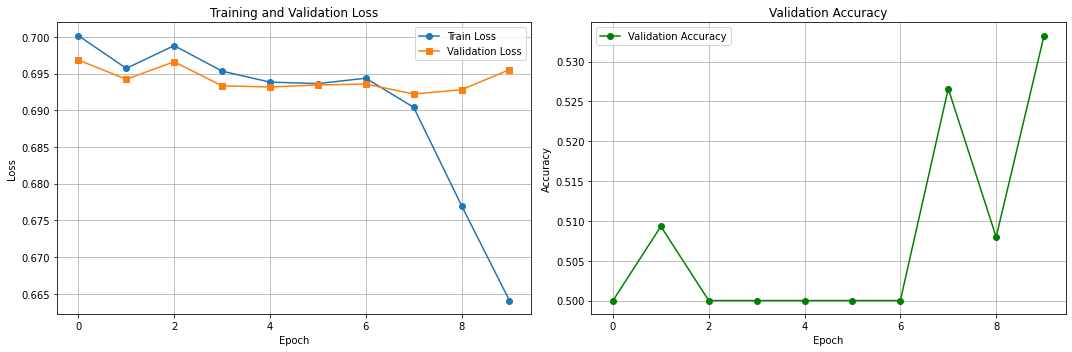

✓ Saved: training_history.png


In [10]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
axes[0].plot(train_losses, label='Train Loss', marker='o')
axes[0].plot(val_losses, label='Validation Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy plot
axes[1].plot(val_accuracies, label='Validation Accuracy', marker='o', color='green')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Validation Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'training_history.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: training_history.png")

## Evaluate Model

✓ Loaded best model from epoch 8


Evaluating: 100%|██████████| 24/24 [00:24<00:00,  1.04s/it]


MODEL EVALUATION RESULTS
Accuracy:  0.5266
Precision: 0.5568
Recall:    0.2606
F1 Score:  0.3551


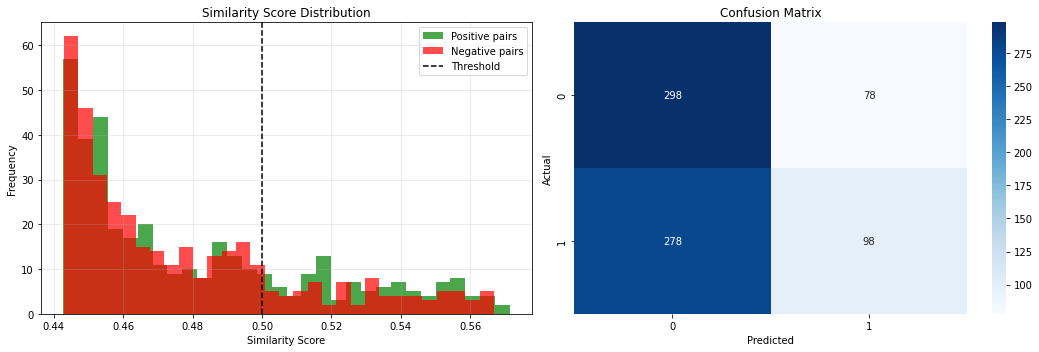

✓ Saved: evaluation_results.png


In [14]:
# Load best model
checkpoint = torch.load(OUTPUT_DIR / 'best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"✓ Loaded best model from epoch {checkpoint['epoch']+1}")

# Evaluate on validation set
model.eval()
all_predictions = []
all_labels = []
all_similarities = []

with torch.no_grad():
    for text1, text2, labels in tqdm(val_loader, desc="Evaluating"):
        text1 = text1.to(DEVICE)
        text2 = text2.to(DEVICE)
        
        similarity, _, _ = model(text1, text2)
        similarity_prob = torch.sigmoid(similarity)
        predictions = (similarity_prob > 0.5).float()
        
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.numpy())
        all_similarities.extend(similarity_prob.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(all_labels, all_predictions)
precision, recall, f1, _ = precision_recall_fscore_support(
    all_labels, all_predictions, average='binary', zero_division=0
)

print("MODEL EVALUATION RESULTS")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

# Plot similarity distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Similarity scores distribution
axes[0].hist([s for s, l in zip(all_similarities, all_labels) if l == 1], 
             bins=30, alpha=0.7, label='Positive pairs', color='green')
axes[0].hist([s for s, l in zip(all_similarities, all_labels) if l == 0], 
             bins=30, alpha=0.7, label='Negative pairs', color='red')
axes[0].axvline(0.5, color='black', linestyle='--', label='Threshold')
axes[0].set_xlabel('Similarity Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Similarity Score Distribution')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('Confusion Matrix')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'evaluation_results.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: evaluation_results.png")

The similarity score distribution shows a large overlap between positive and negative pairs, meaning the model struggles to separate true matches from non-matches. Many negative pairs score above the threshold, and many positive pairs fall below it. The confusion matrix confirms this issue: the model has a high number of false positives and a moderate number of false negatives, indicating that its predictions are only weakly reliable for distinguishing relevant regulation–letter pairs which is to evaluate how well your similarity model can actually distinguish correct matches from incorrect ones. To improve, perhaps use chunks of text rather than full text since regulations are long and explore other models more suitable with regulations.

## Save Model and Vocabulary

In [18]:
# Save final model
torch.save({
    'model_state_dict': model.state_dict(),
    'vocab': vocab,
    'model_config': {
        'embedding_dim': EMBEDDING_DIM,
        'hidden_dim': HIDDEN_DIM,
        'num_layers': NUM_LAYERS,
        'dropout': DROPOUT,
        'max_seq_length': MAX_SEQ_LENGTH,
        'vocab_size': len(vocab)
    },
    'training_config': {
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'num_epochs': NUM_EPOCHS
    }
}, OUTPUT_DIR / 'final_model.pth')

print(f"✓ Final model saved to {OUTPUT_DIR / 'final_model.pth'}")
print(f"✓ Vocabulary saved to {OUTPUT_DIR / 'vocabulary.pkl'}")
print("\n✓ All files saved successfully!")

✓ Final model saved to /Users/Kay Michnicki/AllCode/FDA Data Scraping/siamese_network_output/final_model.pth
✓ Vocabulary saved to /Users/Kay Michnicki/AllCode/FDA Data Scraping/siamese_network_output/vocabulary.pkl

✓ All files saved successfully!
